In [1]:
%%HTML
<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

# Modeling Gene Networks Using Ordinary Differential Equations

Author: Paul M. Magwene 
<br> 
Date: April 2016
- - -

### Background readings

* Shen-Orr, S. S., et al. 2002. Network motifs in the transcriptional regulation network of Escherichia coli. Nat Genet 31(1):64-8. http://dx.doi.org/10.1038/ng881

* Alon, U. 2007. Network motifs: theory and experimental approaches. Nat Rev Genet, 8(6):450–61. http://dx.doi.org/10.1038/nrg2102.

- - -

To gain some intuition for how systems biologists build mathematical models of gene networks we're going to use computer simulations to explore the dynamical behavior of simple gene networks.

In each of our simulations we will keep track of the the concentration of a different proteins of interest as they change over time.  The basic approach we will use to calculate changes in the quantity of different molecules are  differential equations, which are simply a way of describing the instanteous change in a quantity of interest.  

All of our differential equations will be of this form:

\begin{eqnarray*}
\frac{dY}{dt} = \mbox{rate of production} - \mbox{rate of decay}
\end{eqnarray*}

To state this in words --  the amount of gene $Y$  changes over time is a function of two things: 

1. a growth term which represents the rate at which the gene is being transcribed and translated; 
2. a decay term which gives the rate at which $Y$ trascsripts and protein are being degraded.  

In general we will assume that the "rate of production" is a function of the concentration of the genes that regulate $Y$(i.e. it's inputs in the transcriptional network), while the "rate of decay" is a proportional to the amount of $Y$ that is present. So the above formula will take the following structure:

$$
\frac{dY}{dt} =  f(X_1, X_2, \ldots) - \alpha Y
$$

The $f(X_1, X_2, \ldots)$ term represents the growth term and is a function of the transcription factors that regulate $Y$. The term, $\alpha Y$ represents the rate at which $Y$ is being broken down or diluted.  Notice that the decay rate is a proportional to the amount of $Y$ that is present. 

If $\frac{dy}{dt}$ is positive than the concentration of gene $Y$ is increasing, if $\frac{dy}{dt}$ is negative the concentration of $Y$ is decreasing, and if $\frac{dy}{dt} = 0$ than $Y$ is at steady state.

# The Logic Approximation


Enzymatic reactions are usually mathematically modeled using a fuction called the "Hill equation", which describes the rate of production of some product Y, as a function of the concentration of the catalyst X. Depending on its parameters, the Hill equation can vary from a simple hyperbolic curve to a sigmoidal function (see XXXX). We're going to use an approximation to the Hill equation we'll call the "logic approximation", where we'll represent the rate of production of a protein Y as a "piece-wise" constant function like the following.

We'll assume that when the transcription factor, $X$, that is above a threshold, $K$, then  gene $Y$ is transcribed and translated at a rate, $\beta$.  When $X$ is below the threshold, $K$, gene $Y$ is not  transcribed.  To represent this situation,  we can rewrite the formula for $Y$ as:

$$
f(X) = 
\begin{cases}
    0,      &\text{if $X < K$;} \\
    \beta,  &\text{otherwise.}
\end{cases}
$$

When $X$ is a repressor we can write (not that we just changed the less than symbol to a greater than symbol in the first case).

$$
f(X) = 
\begin{cases}
    0,      &\text{if $X > K$;} \\
    \beta,  &\text{otherwise.}
\end{cases}
$$

### Simulating the logic approximation

We can write Python functions to represent the logic approximations for activation and repression as follows:

In [2]:
# import statements to make numeric and plotting functions available
%matplotlib notebook
from numpy import *
from matplotlib.pyplot import *

import ipywidgets as widgets
from IPython.display import display


In [3]:
def logic_activating(X, B, K):
    if X > K:
        theta = 1
    else:
        theta = 0
    return B*theta 

def logic_repressing(X, B, K):
    if X < K:
        theta = 1
    else:
        theta = 0
    return B*theta

And now we can generate some plots to visualize the logic approximations:

<IPython.core.display.Javascript object>


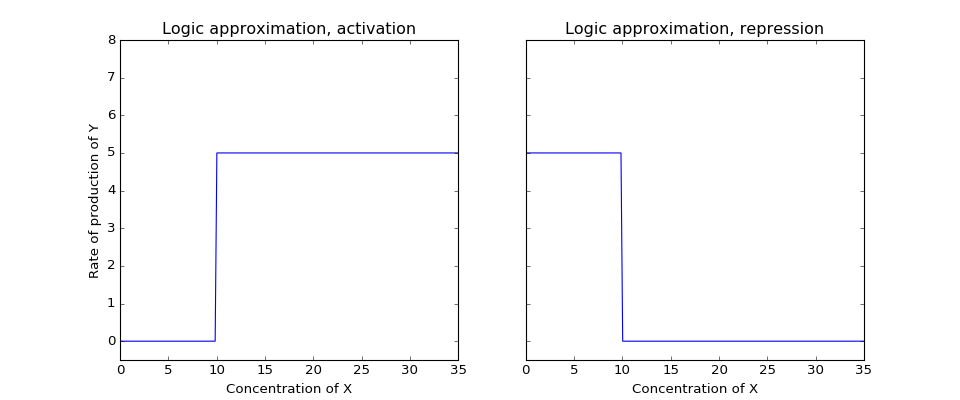

In [4]:
# generate a range of x values, representing a range of concentrations of our
# transcription factor X
x = linspace(0,35,200)  # generate 250 evenly spaced points between 0 and 35

fig, (ax1,ax2) = subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)


def logic_approx_plots(B,K):
    ax1.lines = []
    ax2.lines =  []
    # calculating corresponding rates of production of Y
    y_activation = [logic_activating(i, B, K) for i in x] 
    y_repression = [logic_repressing(i, B, K) for i in x]

    # plot the hill fxn with the user set parameters
    ax1.plot(x, y_activation, label='B = {}, K = {}'.format(B, K), color='b')
    ax1.set_ylim(-0.5,8)
    ax1.set_xlabel('Concentration of X')
    ax1.set_ylabel('Rate of production of Y')
    ax1.set_title('Logic approximation, activation')
    
    ax2.plot(x, y_repression, label='B = {}, K = {}'.format(B, K), color='b')
    ax2.set_xlabel('Concentration of X')
    ax2.set_title('Logic approximation, repression')    

logic_approx_plots(5,10)

In [5]:
widgets.interact(logic_approx_plots, 
                 B=widgets.FloatSlider(min=1,max=7,step=0.25,value=5),
                 K=widgets.FloatSlider(min=1,max=25,step=0.25,value=10))
pass

### Logic approximations for multi-input functions

What if a gene needs two or more activator proteins to be transcribed?  

For example, what if a gene $Z$ is controlled by two other genes $X$ and $Y$, both of which have to be above their respective thresholds for $Z$ to be transcribed (and subsequently translated). We can describe the amount of $Z$ as a function of active forms of $X$ and $Y$ with a function like:

$$
f(X, Y) = 
\begin{cases}
    \beta,      &\text{if $X > K_x$ and $Y > K_y$;} \\
    0,  &\text{otherwise.}
\end{cases}
$$

The above equation describes "AND" logic (i.e. *both* X and Y have to be above their threshold levels, $K_x$ and $K_y$, for Z to be transcribed). In a similar manner we can define "OR" logic:

$$
f(X, Y) = 
\begin{cases}
    \beta,      &\text{if $X > K_x$ or $Y > K_y$;} \\
    0,  &\text{otherwise.}
\end{cases}
$$

If $X$ was an activator and $Y$ was a repressor, one possible representation of this logic could be:

$$
f(X, Y) = 
\begin{cases}
    \beta,      &\text{if $X > K_x$ and $Y < K_y$;} \\
    0,  &\text{otherwise.}
\end{cases}
$$

This could be read as "$Z$ is produced at a rate $\beta$ if $X$ is above the threshold $K_x$ and Y is *below* the threshold $K_y$".  Any number of other scenarious can be modeled using this logic approximation framework. 


# Modeling changes in network components over time

Up until this point we've been considering how the *rate of production* of a protein $Y$ changes with the concentration of a transcriptional activator/repressor that regulates $Y$.  Now we want to turn to the question of how the absolute amount of $Y$ changes over time.

As we discussed at the beginning of this notebook, how the amount of $Y$  changes over time is a function of two things: 

 1. a growth term which represents the rate of production of $Y$
  
 2. a decay term which gives the rate at which $Y$ is degraded.  
 
A  differential equation describing this as follows:

$$
\frac{dY}{dt} =  f(X_1, X_2, \ldots) - \alpha Y
$$

The $f(X_1, X_2, \ldots)$ term represents the growth term and is a function of the transcription factors that regulate $Y$. We've already seen a couple of ways to model the rate of production using the logic approximation. 

The second term, $\alpha Y$ represents the rate at which $Y$ is being broken down or diluted.  Notice that the decay rate is a proportional to the amount of $Y$ that is present.




## Change in  concentration under constant activation

Now let's explore a simple model of regulation for the two gene network, $X \longrightarrow Y$. Here we assume that at time 0 the activator, $X$, rises above the threshold, $K$, necessary to induce transcription of $Y$ at the rate $\beta$.  $X$ remains above this threshold for the entire simulation. Therefore, we can write $dY/dt$ as:

$$
\frac{dY}{dt} =  \beta - \alpha Y
$$



<IPython.core.display.Javascript object>


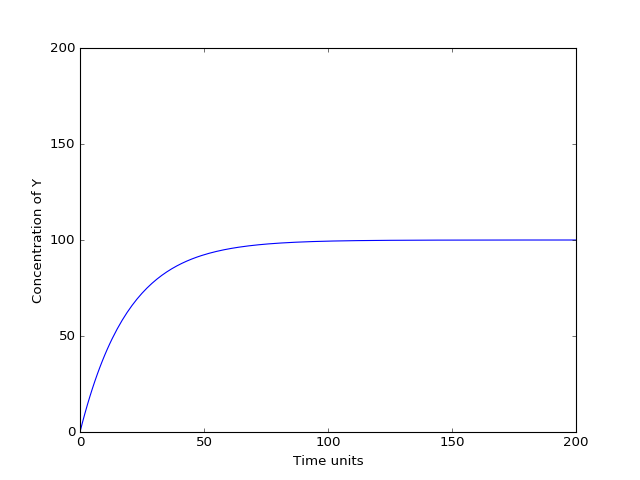

In [6]:
## a function to represent the simple differential equation above

def dYdt(B, K, a, X, Y):
    production = logic_activating(X, B, K)
    decay = a*Y
    return production - decay


fig, ax1b = subplots(1, 1)

def constant_activation(B,a):
    ## generate a plot of conc of Y over time using your dY function defined above
    ## Evaluated over 200 time units
    K = 0
    X = K + 1

    Y = [0] # initial value of Y
    nsteps = 200

    for i in range(nsteps):
        yprevious = Y[-1]
        deltay = dYdt(B, K, a, X, yprevious)
        ynew = Y[-1] + deltay
        Y.append(ynew)
        
    ax1b.lines = []
    ax1b.plot(Y, 'b')
    ax1b.set_xlabel('Time units')
    ax1b.set_ylabel('Concentration of Y')
    ax1b.set_ylim(0, 200)
    pass    

constant_activation(5,0.05)



In [7]:

widgets.interact(constant_activation, 
                 B=widgets.FloatSlider(min=1,max=5,step=0.25,value=5,description=r"$\beta$"),
                 a=widgets.FloatSlider(min=0.01,max=0.20,step=0.01,value=0.05,description=r'$\alpha$'))
pass

## Toggling the activator X

In the proceeding example the activator $X$ was on at the beginning of the simulation and just stayed on.  Let's see what happens when $X$ has pulsatile dynamics.  This would be akin to  toggling $X$ on then off, and asking what happens to $Y$.

<IPython.core.display.Javascript object>


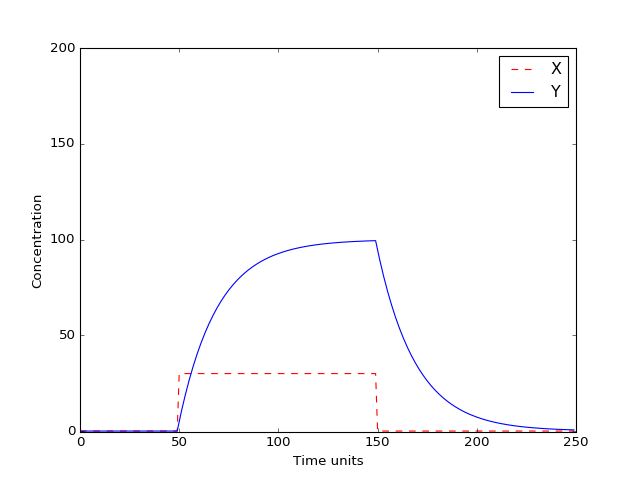

In [8]:

fig, ax1c = subplots(1,1)
def pulsed_activation(B,a):
    K = 10
    # setup pulse of X
    # off (0) for first 50 steps, on for next 100 steps, off again for last 100 steps
    X = [0]*50 + [3*K]*100 + [0]*100

    Y = [0] # initial value of Y

    nsteps = 250
    for i in range(1, nsteps):
        xnow = X[i]
        yprevious = Y[-1]
        deltay = dYdt(B, K, a, xnow, yprevious)
        ynew = yprevious + deltay
        Y.append(ynew)

    ax1c.lines = []
    ax1c.plot(X, color='red', linestyle='dashed', label="X")
    ax1c.plot(Y, color='blue', label="Y")
    #ylim(-0.5, max(max(X)*1.1, (B/a)*1.1))
    ax1c.set_ylim(-0.5, 200)
    ax1c.set_xlabel('Time units')
    ax1c.set_ylabel('Concentration')
    ax1c.legend(loc="best")
    pass


pulsed_activation(5,0.05)


In [9]:
widgets.interact(pulsed_activation, 
                 B=widgets.FloatSlider(min=1,max=5,step=0.25,value=5,description=r"$\beta$"),
                 K=widgets.FloatSlider(min=1,max=25,step=0.25,value=10,description="$K_x$"),
                 a=widgets.FloatSlider(min=0.01,max=0.20,step=0.01,value=0.05,description=r'$\alpha$'))
pass

# Feed Forward Loops

We're now going to use some of these tools to look at a class of network motifs (small network topologies), called Feed Forward Loops (FFLs), found in signaling and regulatory networks. FFLs involve interactions between three components, with the basic topology illustrated below. Depending on the signs of the edges (whether activating or repressing) we can classify FFLs as "coherent" or "incoherent." We'll take a look at an example of each class.


## A Coherent FFL

The most common type of coherent FFL is illustrated in the figure below.  In this system $X$ is an activator of $Y$ and both $X$ and $Y$ regulate the production of $Z$ with AND logic (i.e. both $X$ and $Y$ must be above particular thresholds in order to trigger the production of $Z$). 

![coherent ffl](http://people.duke.edu/~pm21/coherent-ffl.png)
Using our logic approximation framework we will model the coherent FFL network illustrated above as follows.


#### Gene Y:


$$
\text{production of Y} = f(X) = 
\begin{cases}
    \beta_y, &\text{if $X > K_{x}$;} \\
    0, &\text{otherwise.}
\end{cases}
$$

$$
\frac{dY}{dt} = f(X) - \alpha_{y}Y
$$    
    
    
#### Gene Z:


$$
\text{production of Z} = g(X, Y) = 
\begin{cases}
    \beta_z,      &\text{if $X > K_{x,z}$ and $Y > K_{y,z}$;} \\
    0,  &\text{otherwise.}
\end{cases}
$$

$$
\frac{dZ}{dt} = g(X,Y) - \alpha_{z}Z
$$



<IPython.core.display.Javascript object>


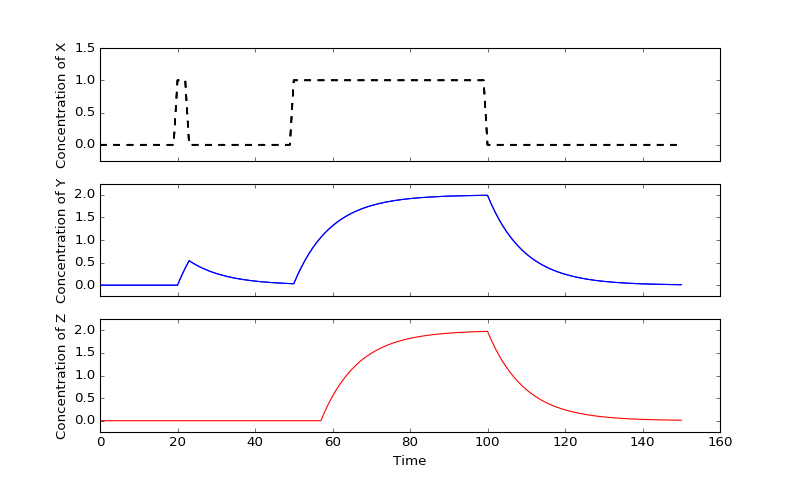

In [10]:
## We'll specify the behavior of X as a series of pulse of different length
## so we'll define a function to generate pulses

def pulse(ontime, offtime,  ntimes, onval=1):
    if ontime >= offtime:
        raise Exception("Invalid on/off times.")
    signal = np.zeros(ntimes)
    signal[ontime:offtime] = onval
    return signal


def dYdt(B, K, a, X, Y):
    if X > K:
        theta = 1
    else:
        theta = 0
    return B * theta - a * Y


def dZdt(B, Kx, Ky, a, X, Y, Z):
    theta = 0
    if (X > Kx) and (Y > Ky):
        theta = 1
    return B * theta - a * Z

fig, (ax1d, ax2d, ax3d) = subplots(3,1,figsize=(10,6),sharex=True,sharey=False)

def coherent_ffl(By,Bz,Kxy,Kxz,Kyz,alphay,alphaz):
    ## Plot X, Y, and Z on the same time scale

    nsteps = 150
    short_pulse = pulse(20, 23, nsteps)  # 5 sec pulse
    long_pulse = pulse(50, 100, nsteps)  # 50 sec pulse
    X = short_pulse + long_pulse

    # setup parameters for Y and Z
    Y = [0]
    Z = [0]
    
    for i in range(nsteps):
        xnow = X[i]
        ynow, znow = Y[-1], Z[-1]

        ynew = ynow + dYdt(By, Kxy, alphay, xnow, ynow)
        znew = znow + dZdt(Bz, Kxz, Kyz, alphaz, xnow, ynow, znow)

        Y.append(ynew)
        Z.append(znew)

    ax1d.lines = ax2d.lines = ax3d.lines = []

    ax1d.plot(X, 'k--', label='X', linewidth=1.5)
    ax2d.plot(Y, 'b', label='Y')
    ax3d.plot(Z, 'r', label='Z')
    
    ax1d.set_ylim(-0.25,1.5)
    ax2d.set_ylim(-0.25,2.25)
    ax3d.set_ylim(-0.25,2.25)
    
    ax3d.set_xlabel("Time")
    ax1d.set_ylabel("Concentration of X")
    ax2d.set_ylabel("Concentration of Y")
    ax3d.set_ylabel("Concentration of Z")
    


coherent_ffl(0.2,0.2,0.5,0.5,1,0.1,0.1)

In [11]:
by=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=0.2)
bz=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=0.2)
kxy=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.5)
kxz=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.5)
kyz=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=1)
ay = widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.1)
az = widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.1)
    
widgets.interact(coherent_ffl, 
                 By=by,
                 Bz=bz,
                 Kxy=kxy,
                 Kxz=kxz,
                 Kyz=kyz,
                 alphay = ay,
                 alphaz = az
                )
pass

# Performance of the Coherent FFL under noisy inputs

Let's further explore the behavior of the coherent FFL defined given noisy inputs.  As before we're going to define an input signal, $X$, that has a short and long pulse, but now we're going to pollute $X$ with random noise.

<IPython.core.display.Javascript object>


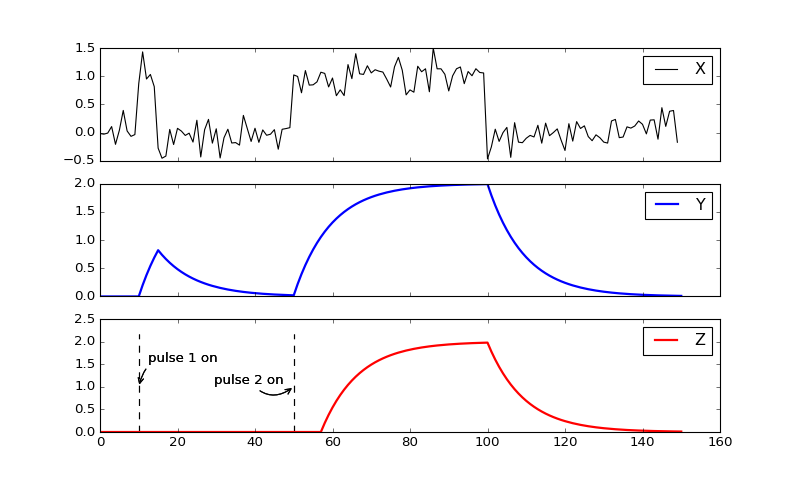

In [12]:
nsteps = 150

p1start = 10
p1duration = 5

p2start = 50
p2duration = 50


fig, (ax1e,ax2e,ax3e) = subplots(3,1,figsize=(10,6),sharex=True,sharey=False)

def noisy_coherent_ffl(By,Bz,Kxy,Kxz,Kyz,alphay,alphaz, noise):
    short_pulse = pulse(p1start, p1start + p1duration, nsteps)  # short pulse
    long_pulse = pulse(p2start, p2start + p2duration, nsteps)  # long pulse
    X = short_pulse + long_pulse 
    
    noise = np.random.normal(loc=0, scale=noise, size=nsteps) # mean=0, sd=0.2

    X = X + noise
    Y = [0]
    Z = [0]

    for i in range(nsteps):
        xnow = X[i]
        ynow, znow = Y[-1], Z[-1]
        ynew = ynow + dYdt(By, Kxy, alphay, xnow, ynow)
        znew = znow + dZdt(Bz, Kxz, Kyz, alphaz, xnow, ynow, znow)
        Y.append(ynew)
        Z.append(znew)
        
    
    ax1e.lines = []
    ax2e.lines = []
    ax3e.lines = []
    
    ax1e.plot(X, 'k', label='X', linewidth=1)
    ax1e.legend()

    ax2e.plot(Y, 'b', label='Y', linewidth=2)
    ax2e.legend()

    ax3e.plot(Z, 'r', label='Z', linewidth=2)

    ax3e.vlines(p1start, min(Z),max(Z)*1.1,color='black',linestyle='dashed')
    ax3e.annotate("pulse 1 on", xy=(p1start,1),xytext=(40,20),
             textcoords='offset points',
             horizontalalignment="center",
             verticalalignment="bottom",
             arrowprops=dict(arrowstyle="->",color='black',
                             connectionstyle='arc3,rad=0.5',
                             linewidth=1))
    ax3e.vlines(p2start, min(Z),max(Z)*1.1,color='black',linestyle='dashed')
    ax3e.annotate("pulse 2 on", xy=(p2start,1),xytext=(-40,0),
             textcoords='offset points',
             horizontalalignment="center",
             verticalalignment="bottom",
             arrowprops=dict(arrowstyle="->",color='black',
                             connectionstyle='arc3,rad=0.5',
                             linewidth=1))
    ax3e.legend()


noisy_coherent_ffl(0.2,0.2,0.5,0.5,1,0.1,0.1,0.2)
pass

In [13]:
by=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=0.2)
bz=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=0.2)
kxy=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.5)
kxz=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.5)
kyz=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=1)
ay = widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.1)
az = widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.1)
nz = widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.2)
    
widgets.interact(noisy_coherent_ffl,
                 By=by,
                 Bz=bz,
                 Kxy=kxy,
                 Kxz=kxz,
                 Kyz=kyz,
                 alphay = ay,
                 alphaz = az,
                 noise = nz
                )
pass


### Dynamics of Y and Z in the Coherent FFL

As before we can solve for Y as a function of time and calculate what its steady state value will be:

$$
Y(t) = Y_{st}(1-e^{-\alpha_{y}t})
$$

and 

$$
Y_{st}=\frac{\beta_y}{\alpha_y}
$$

#### How about $Z$? 

Since $Z$ is governed by an AND function it needs both $X$ and $Y$ to be above their respective thresholds, $K_{xz}$ and $K_{yz}$. For the sake of simplicity let's assume that both $Y$ and $Z$ have the same threshold with respect to $X$, i.e. $K_{xy} = K_{xz}$. This allows us just to consider how long it takes for $Y$ to reach the threshold value $K_{yz}$. Given this we can calculate the delay before $Z$ turns on, $T_{\mathrm{on}}$ as follows.

$$
Y(T_{\mathrm{on}}) = Y_{st}(1-e^{-\alpha_y T_{\mathrm{on}}}) = K_{yz}
$$

and solving for $T_{\mathrm{on}}$ we find:

$$
T_{\mathrm{on}} = \frac{1}{\alpha_y} \log\left[\frac{1}{(1-K_{yz}/Y_{st})}\right]
$$

Thus we see that the delay before $Z$ turns on is a function of the degradation rate of $Y$ and the ratio between $Y_{st}$ and $K_{yz}$.  

#### Exploring the Parameter space of $Z$'s turn-on time

From the above formula, we see that there are two parameters that affect the turn-on time of $Z$ -- $\alpha_y$ (the scaling factor for the decay rate of $Y$)  and the compound parameter $K_{yz}/Y_{st}$ (the threshold concentration where $Y$ activate $Z$ relative to the steady state of $Y$).  To explore the two-dimensional parameter space of $Z's$ $T_on$ we can create a contour plot.

<IPython.core.display.Javascript object>


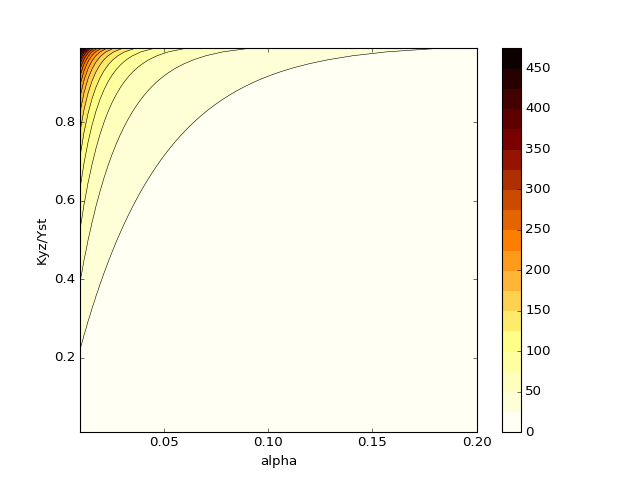

In [14]:
def Ton(alpha, KYratio):
    return (1.0/alpha) * log(1.0/(1.0-KYratio))

## Create a contour plot for a range of alpha and Kyz/Yst
x = alpha = linspace(0.01, 0.2, 100)
y = KYratio = linspace(0.01, 0.99, 100)
X,Y = meshgrid(x, y)

Z = Ton(X,Y)
levels = MaxNLocator(nbins=20).tick_values(Z.min(), Z.max())

fig,axf = subplots(1,1)


im = contourf(X,Y,Z, cmap=cm.afmhot_r, levels=levels)
axf.contour(X, Y, Z, levels,
                  colors=('k',),
                  linewidths=(0.5,))
colorbar(im)
axf.set_xlabel('alpha')
axf.set_ylabel("Kyz/Yst")
pass

## Type 1 Coherent FFLs can act as a Sign-Sensitive Delays

As discussed in the article by Shen-Orr et al. a feed forward loop of the type we've just discussed can act as a type of filter -- a sign-sensitive delay that keeps $Z$ from firing in response to transient noisy signals from $X$, but shuts down $Z$ immediately once the signal from $X$ is removed. 

# An Incoherent FFL

Consider the FFL illustrated in the figure below.  

![incoherent ffl](http://people.duke.edu/~pm21/incoherent-ffl.png)

In this incoherent FFL, the logic function that regulates $Z$ is "X AND NOT Y".  That is $Z$ turns on once $X$ is above a given threshold, but only stays on fully as long as $Y$ is below another threshold. Again for simplicity we assume $K_{xy} = K_{yz}$. 

<IPython.core.display.Javascript object>


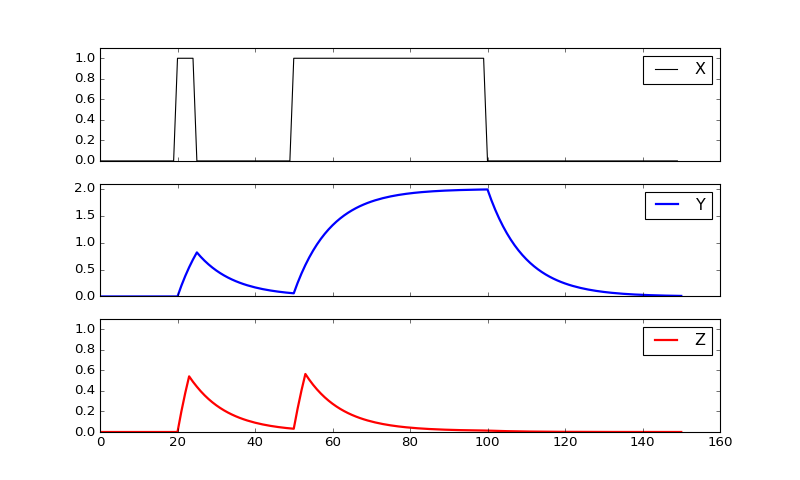

In [15]:

def dZ_incoh(B1,B2,Kx,Ky,a,X,Y,Z):
    theta = 0
    B = 0
    if (X > Kx) and (Y < Ky):
        theta = 1
        B = B1
    elif (X > Kx) and (Y >= Ky):
        theta = 1
        B = B2
    return B * theta - a * Z


fig, (ax1g,ax2g,ax3g) = subplots(3,1,figsize=(10,6),sharex=True,sharey=False)


def incoherent_ffl(By,Bz1,Bz2,Kxy,Kxz,Kyz,alphay,alphaz):
    nsteps = 150
    short_pulse = pulse(20, 25, nsteps)  # 5 sec pulse
    long_pulse = pulse(50, 100, nsteps)  # 50 sec pulse
    X = short_pulse + long_pulse
    # setup parameters for Y and Z
    Y = [0]
    Z = [0]

    for i in range(nsteps):
        xnow = X[i]
        ynow, znow = Y[-1], Z[-1]

        ynew = ynow + dYdt(By, Kxy, alphay, xnow, ynow)
        znew = znow + dZ_incoh(Bz1, Bz2, Kxz, Kyz, alphaz, xnow, ynow, znow)

        Y.append(ynew)
        Z.append(znew)

    ax1g.lines = []
    ax2g.lines = []
    ax3g.lines = []
    
    ax1g.plot(X, 'k', label='X', linewidth=1)
    ax1g.legend()
    ax1g.set_ylim(0,1.1)
    
    ax2g.plot(Y, 'b', label='Y', linewidth=2)
    ax2g.legend()
    ax2g.set_ylim(0,2.1)
     
    ax3g.plot(Z, 'r', label='Z', linewidth=2)
    ax3g.legend()
    ax3g.set_ylim(0,1.1)
    
    
    
betay = 0.2
alphay = 0.1
Kxy = 0.5

betaz1, betaz2 = 0.2, 0.001
alphaz = 0.1
Kxz = 0.5
Kyz = 0.5
incoherent_ffl(betay, betaz1, betaz2, Kxy, Kxz, Kyz, alphay, alphaz)


In [16]:
by=widgets.FloatSlider(min=0,max=2,step=0.1,value=0.2)
bz1=widgets.FloatSlider(min=0,max=2,step=0.1,value=0.2)
bz2=widgets.FloatSlider(min=0,max=2,step=0.001,value=0.001)
kxy=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.5)
kxz=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.5)
kyz=widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.5)
ay = widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.1)
az = widgets.FloatSlider(min=0.1,max=1,step=0.1,value=0.1)
    
widgets.interact(incoherent_ffl,
                 By=by,
                 Bz1=bz1,
                 Bz2=bz2,
                 Kxy=kxy,
                 Kxz=kxz,
                 Kyz=kyz,
                 alphay = ay,
                 alphaz = az,
                )
pass

### Dynamics of the Incoherent FFL

Note that the stimulus amount of $Z$ in the system initially increases, but then decreases to a lower steady even when the initial stimulus persists. This system thus generates **pulse-like dynamics to a persistent signal**. How pulse-like the signal is depends on the ratio of $\beta_z$ to $\beta_{z}^{'}$. We define the repression factor, $F$, as follows:

$$
F = \frac{\beta_z}{\beta_{z}^{'}} = \frac{Z_m}{Z_{st}}
$$



In [17]:
%%HTML
<a href="javascript:code_toggle()">[Toggle Code]</a>